In [ ]:
# Pandas
import pandas as pd
import numpy as np
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Carrega dados
url = 'https://raw.githubusercontent.com/MDices/datasets/main/vgsales.csv'
data = pd.read_csv(url, sep=',')
data.head(15)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [ ]:
data['Publisher'].value_counts()

Electronic Arts                 1351
Activision                       975
Namco Bandai Games               932
Ubisoft                          921
Konami Digital Entertainment     832
                                ... 
Warp                               1
New                                1
Elite                              1
Evolution Games                    1
UIG Entertainment                  1
Name: Publisher, Length: 578, dtype: int64

In [ ]:
#nintendo = data
nintendo = data[data['Publisher'] == "Nintendo"]
nintendo.shape

(703, 11)

In [ ]:
nintendo = nintendo.drop(["Rank", "Name", "Platform", "Genre", "Publisher", "EU_Sales", "Other_Sales", "Global_Sales"], axis = 1)

In [ ]:
nintendo['Year'] = pd.to_datetime(nintendo['Year'], format='%Y')
nintendo['Year'] = nintendo['Year'].dt.strftime('%Y')
nintendo.shape

(703, 3)

In [ ]:
nintendo[nintendo['Year'] == None]
contagem_nan = nintendo.isna().sum()
print(contagem_nan)
nintendo.shape
nintendo.dropna(inplace=True)
contagem_nan = nintendo.isna().sum()
print(contagem_nan)
nintendo.shape

Year        7
NA_Sales    0
JP_Sales    0
dtype: int64
Year        0
NA_Sales    0
JP_Sales    0
dtype: int64


(696, 3)

In [ ]:
#nintendo.dropna(inplace=True)
nintendo['year_month'] = pd.to_datetime(nintendo['Year'].astype(str) + '-' + '01')
nintendo_monthly = nintendo.groupby(['year_month'])['NA_Sales'].mean().reset_index()
nintendo_monthly = nintendo.groupby(['year_month'])['JP_Sales'].mean().reset_index()

In [ ]:
# Converte data de string para datetime e transforma em índice
nintendo['Year2'] = nintendo['Year']
nintendo.index = pd.to_datetime(nintendo['Year'])

nintendo_by_year = nintendo.groupby(pd.Grouper(freq='MS')).mean()
nintendo_by_year.fillna(0.0, inplace=True)
#nintendo_by_year = nintendo_by_year.loc[nintendo_by_year.index <= '2018-12-01']
nintendo_by_year.shape

<ipython-input-561-810f62139b5f>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nintendo_by_year = nintendo.groupby(pd.Grouper(freq='MS')).mean()


(397, 2)

In [ ]:
a_year = 0
sales = 0
for date in pd.date_range(start=nintendo_by_year.index.min(), end=nintendo_by_year.index.max(), freq='MS'):
    if a_year != int(date.strftime('%Y')):
      a_year = int(date.strftime('%Y'))

      if int(date.strftime('%m')) == 1:
        GB_sales = nintendo_by_year.loc[date, 'NA_Sales']
        JP_sales = nintendo_by_year.loc[date, 'JP_Sales']
        #print("antes de dividir",sales, "data ref", date)
        GB_sales = GB_sales / 12

      nintendo_by_year.loc[date, 'NA_Sales'] = GB_sales
      nintendo_by_year.loc[date, 'JP_Sales'] = JP_sales
    a_year = date.strftime('%Y')
    a_month = int(date.strftime('%m'))

nintendo_by_year.tail(36)
#print(f"Vendas do mês de {date.strftime('%B %Y')}: {month_sales}")

,NA_Sales,JP_Sales
Year,,
2013-02-01,0.068841,0.625652
2013-03-01,0.068841,0.625652
2013-04-01,0.068841,0.625652
2013-05-01,0.068841,0.625652
2013-06-01,0.068841,0.625652
2013-07-01,0.068841,0.625652
2013-08-01,0.068841,0.625652
2013-09-01,0.068841,0.625652
2013-10-01,0.068841,0.625652


In [ ]:
nintendo_by_year.head(24)

,NA_Sales,JP_Sales
Year,,
1983-01-01,0.032222,1.350000
1983-02-01,0.032222,1.350000
1983-03-01,0.032222,1.350000
1983-04-01,0.032222,1.350000
1983-05-01,0.032222,1.350000
1983-06-01,0.032222,1.350000
1983-07-01,0.032222,1.350000
1983-08-01,0.032222,1.350000
1983-09-01,0.032222,1.350000


In [ ]:
nintendo_by_year = nintendo_by_year.loc[nintendo_by_year.index <= '2018-12-01']
nintendo_by_year.shape

(397, 2)

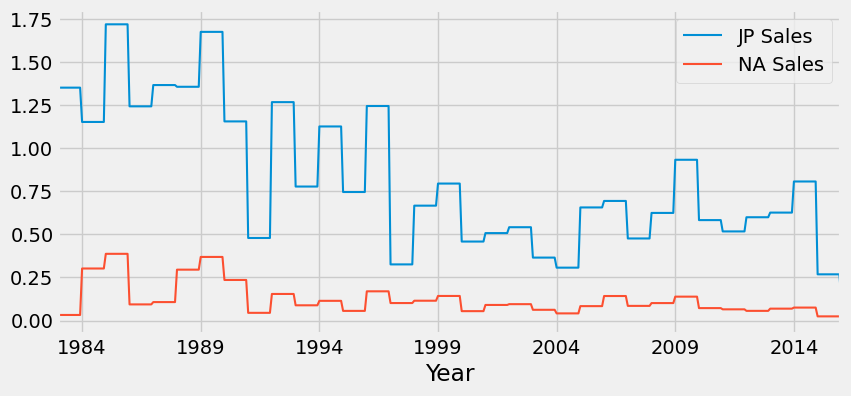

In [ ]:
# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
nintendo_by_year['JP_Sales'].plot(ax=ax, label='JP Sales')
nintendo_by_year['NA_Sales'].plot(ax=ax, label='NA Sales')
ax.legend();

In [ ]:
print(f'Number of rows with missing values: {nintendo_by_year.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Train dates : 1983-01-01 00:00:00 --- 2009-04-01 00:00:00  (n=316)
Test dates  : 2009-05-01 00:00:00 --- 2016-01-01 00:00:00  (n=81)


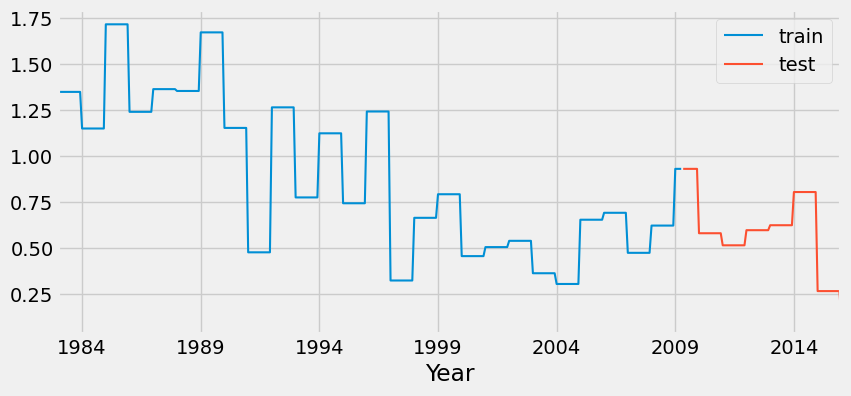

In [ ]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 81
data_train = nintendo_by_year[:-steps]
data_test  = nintendo_by_year[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['JP_Sales'].plot(ax=ax, label='train')
data_test['JP_Sales'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 81
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['JP_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:14<00:00, 37.12s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.12125967844634046



In [ ]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123),
                lags      = 20
             )

forecaster.fit(y=data_train['JP_Sales'], exog=data_train['NA_Sales'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: NA_Sales 
Training range: [Timestamp('1983-01-01 00:00:00'), Timestamp('2009-04-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-27 01:33:06 
Last fit date: 2023-04-27 01:3

In [ ]:
# Faz predição no conjunto de teste
steps = 81
predictions = forecaster.predict(steps=steps, exog=data_test['NA_Sales'])
predictions.head(5)

2009-05-01    0.920132
2009-06-01    0.911222
2009-07-01    0.900478
2009-08-01    0.898632
2009-09-01    0.894867
Freq: MS, Name: pred, dtype: float64

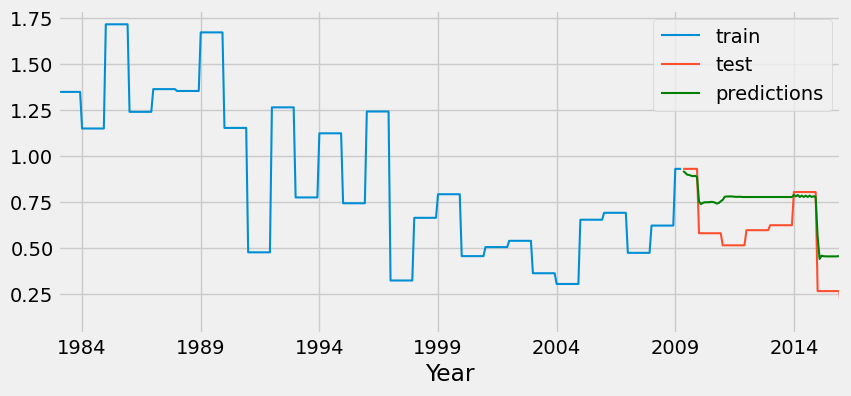

In [ ]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['JP_Sales'].plot(ax=ax, label='train')
data_test['JP_Sales'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();